#Питоновская реализация EM алгоритма

Полезно проделать, чтобы разобраться в numpy и в том, как эффективно писать на питоне.

In [2]:
import numpy as np
import scipy
import scipy.sparse
from sklearn.datasets import fetch_20newsgroups
import gensim
from collections import Counter
import heapq
import nltk
from nltk.corpus import stopwords
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

Нужно скачать некоторые коллекции данных и установить библиотеки (nltk, gensim)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/tylorn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
english_stopwords = set(stopwords.words('english'))

## Исходники, можно пропускать

In [5]:
def trivial_p_dwt_processor(p_dwt):
    pass

def create_frac_of_max_p_dwt_processor(frac_size):
    def fun(p_dwt):
        maximums = np.max(p_dwt, axis=1)
        p_dwt[p_dwt < frac_size * maximums[:, np.newaxis]] = 0.
        p_dwt /= (np.sum(p_dwt, axis=1)[:, np.newaxis] + 1e-10)
    return fun

In [6]:
def perform_e_step_update(it_num, freq_matrix, docptr, phi_matrix, theta_matrix, params):
    block_size = params.get('block_size', 1)
    p_dwt_processor = params.get('p_dwt_processor', lambda x: None)
    event_handler = params.get('event_handler', EmptyHandler())
    
    D, W = freq_matrix.shape
    T = phi_matrix.shape[0]
    n_wt, n_dt = np.zeros((W, T)), np.zeros((D, T))
    transposed_phi_matrix = np.transpose(phi_matrix)
    
    indices = freq_matrix.indices
    indptr = freq_matrix.indptr
    data = freq_matrix.data
    
    for block_num in xrange((D + block_size - 1) / block_size):
        block_start = block_num * block_size
        block_finish = min(D, block_start + block_size)
        ind_start, ind_finish = indptr[block_start], indptr[block_finish]
        
        datas = data[ind_start:ind_finish]
        words = indices[ind_start:ind_finish]
        docs = docptr[ind_start:ind_finish]
        
        p_dwt = transposed_phi_matrix[words] * theta_matrix[docs, :]
        p_dwt /= (np.sum(p_dwt, axis=1)[:, np.newaxis] + 1e-20)
        p_dwt_processor(p_dwt)
        p_dwt *= datas[:, np.newaxis]
        
        for doc_num in xrange(block_start, block_finish):
            doc_start, doc_finish = indptr[doc_num], indptr[doc_num + 1]
            doc_p_dwt = p_dwt[(doc_start - ind_start):(doc_finish - ind_start), :]
            n_dt[doc_num, :] += np.sum(doc_p_dwt, axis=0)
            n_wt[indices[doc_start:doc_finish], :] += doc_p_dwt
            
    event = {
        'n_wt': n_wt,
        'n_dt': n_dt,
        'freq_matrix': freq_matrix,
        'phi_matrix': phi_matrix,
        'theta_matrix': theta_matrix,
        'docptr': docptr,
        'it_num': it_num
    }
    event_handler.handle(event)

    return n_wt, n_dt

In [7]:
def launch_em(
    freq_matrix, 
    phi_matrix,
    theta_matrix,
    regularizations_list,
    params_list,
    iters_count=100
):
    phi_matrix = np.copy(phi_matrix)
    theta_matrix = np.copy(theta_matrix)
    docptr = []
    indptr = freq_matrix.indptr
    for doc_num in xrange(D):
        docptr.extend([doc_num] * (indptr[doc_num + 1] - indptr[doc_num]))
    docptr = np.array(docptr)
    
    for it in xrange(iters_count):
        n_wt, n_dt = params_list[it]['method'](it, freq_matrix, docptr, phi_matrix, theta_matrix, params_list[it])
        r_wt, r_dt = regularizations_list[it](n_wt, n_dt, phi_matrix, theta_matrix)
        n_wt = np.maximum(n_wt + r_wt, 0)
        n_dt = np.maximum(n_dt + r_dt, 0)
        n_wt /= np.sum(n_wt, axis=0)
        n_dt /= np.sum(n_dt, axis=1)[:, np.newaxis]
        phi_matrix = np.transpose(n_wt)
        theta_matrix = n_dt
        
    return phi_matrix, theta_matrix

In [8]:
def trivial_regularization(n_wt, n_dt, phi_matrix, theta_matrix):
    return 0., 0.

def calculate_decorr(phi_matrix):
    aggr_phi = np.sum(phi_matrix, axis=1)
    return np.sum(phi_matrix * (aggr_phi[:, np.newaxis] - phi_matrix))

def create_reg_decorr_naive(tau, theta_alpha=0.):
    def fun (n_wt, n_dt, phi_matrix, theta_matrix):
        aggr_phi = np.sum(phi_matrix, axis=1)
        return - tau * np.transpose(phi_matrix * (aggr_phi[:, np.newaxis] - phi_matrix)), theta_alpha
    return fun

def create_reg_lda(phi_alpha, theta_alpha):
    def fun (n_wt, n_dt, phi_matrix, theta_matrix):
        return phi_alpha, theta_alpha
    return fun

def create_reg_decorr_unbiased(tau, theta_alpha=0.):
    def fun (n_wt, n_dt, phi_matrix, theta_matrix):
        tmp_phi =  n_wt / np.sum(n_wt, axis=0)
        aggr_phi = np.sum(tmp_phi, axis=0)
        return - tau * tmp_phi * (aggr_phi[np.newaxis, :] - tmp_phi), theta_alpha
    return fun

def calculate_likelihood(freq_matrix, docptr, phi_matrix, theta_matrix, block_size=1):
    D, W = freq_matrix.shape
    T = phi_matrix.shape[0]
    transposed_phi_matrix = np.transpose(phi_matrix)
    
    indices = freq_matrix.indices
    indptr = freq_matrix.indptr
    data = freq_matrix.data
    
    res = 0.
    for block_num in xrange((D + block_size - 1) / block_size):
        block_start = block_num * block_size
        block_finish = min(D, block_start + block_size)
        ind_start, ind_finish = indptr[block_start], indptr[block_finish]
        
        datas = data[ind_start:ind_finish]
        words = indices[ind_start:ind_finish]
        docs = docptr[ind_start:ind_finish]
        
        p_dwt = transposed_phi_matrix[words] * theta_matrix[docs, :]
        res += np.sum(np.log(np.sum(p_dwt, axis=1) + 1e-20) * datas)
    
    return res


def external_calculate_likelihood(freq_matrix, phi_matrix, theta_matrix):
    docptr = []
    indptr = freq_matrix.indptr
    for doc_num in xrange(D):
        docptr.extend([doc_num] * (indptr[doc_num + 1] - indptr[doc_num]))
    docptr = np.array(docptr)
    
    return calculate_likelihood(freq_matrix, docptr, phi_matrix, theta_matrix, block_size=50)

def external_calculate_perplexity(freq_matrix, phi_matrix, theta_matrix):
    likelihood = external_calculate_likelihood(freq_matrix, phi_matrix, theta_matrix)
    return np.exp(- likelihood / freq_matrix.sum())

class EmptyLogger(object):
    def iteration(*args):
        pass
    def final_info(self, ):
        pass
    
class DecorrWatcher(object):
    def __init__(self, tau):
        self.tau = tau

    def iteration(self, iter_num, freq_matrix, docptr, phi_matrix, theta_matrix, res):
        print iter_num
        likelihood = calculate_likelihood(freq_matrix, docptr, phi_matrix, theta_matrix, 50)
        decorr = calculate_decorr(phi_matrix)
        print 'L', likelihood
        print 'decorr', decorr
        print 'L + tau R', likelihood - self.tau * decorr
        non_zeros = np.sum(phi_matrix > 1e-20)
        size = phi_matrix.shape[0] * phi_matrix.shape[1]
        print 'Phi non zeros elements', non_zeros, '   fraction', round(1. * non_zeros / size, 2)
        non_zeros = np.sum(theta_matrix > 1e-20)
        size = theta_matrix.shape[0] * theta_matrix.shape[1]
        print 'Theta non zeros elements', non_zeros, '   fraction', round(1. * non_zeros / size, 2)
    def final_info(self):
        pass


class EmptyHandler(object):
    def requires(self, name):
        return False
        
    def handle(self, event):
        pass
    
    def final(self):
        pass
            


In [9]:
def prepare_dataset(dataset):
    # remove stopwords
    occurences = Counter()
    for i, doc in enumerate(dataset.data):
        tokens = gensim.utils.lemmatize(doc)
        for token in set(tokens):
            occurences[token] += 1
        if i % 500 == 0:
            print 'Processed: ', i, 'documents from', len(dataset.data)
    
    row, col, data = [], [], []
    token_2_num = {}
    for i, doc in enumerate(dataset.data):
        tokens = gensim.utils.lemmatize(doc)
        cnt = Counter()
        for token in tokens:
            word = token.split('/')[0]
            if word not in english_stopwords and 10 <= occurences[token] < len(dataset.data) / 2:
                if token not in token_2_num:
                    token_2_num[token] = len(token_2_num)
                cnt[token_2_num[token]] += 1
        for w, c in cnt.iteritems():
            row.append(i)
            col.append(w)
            data.append(c)
        
    num_2_token = {
        v: k
        for k, v in token_2_num.iteritems()
    }
    print 'Nonzero values:', len(data)
    return scipy.sparse.csr_matrix((data, (row, col))), token_2_num, num_2_token


In [10]:
def prepare_dataset_with_cooccurences(dataset):
    # remove stopwords
    occurences = Counter()
    cooccurences = Counter()
    for i, doc in enumerate(dataset.data):
        tokens = gensim.utils.lemmatize(doc)
        for token in set(tokens):
            occurences[token] += 1
        if i % 500 == 0:
            print 'Preprocessed: ', i, 'documents from', len(dataset.data)
    
    row, col, data = [], [], []
    token_2_num = {}
    for i, doc in enumerate(dataset.data):
        tokens = gensim.utils.lemmatize(doc)
        cnt = Counter()
        words_set = set()
        for token in tokens:
            word = token.split('/')[0]
            if word not in english_stopwords and 10 <= occurences[token] < len(dataset.data) / 2:
                if token not in token_2_num:
                    token_2_num[token] = len(token_2_num)
                words_set.add(token_2_num[token])
                cnt[token_2_num[token]] += 1
        for w, c in cnt.iteritems():
            row.append(i)
            col.append(w)
            data.append(c)
            
        for w1 in words_set:
            for w2 in words_set:
                cooccurences[(w1, w2)] += 1
                
        if i % 500 == 0:
            print 'Processed: ', i, 'documents from', len(dataset.data)
        
    num_2_token = {
        v: k
        for k, v in token_2_num.iteritems()
    }
    print 'Nonzero values:', len(data)
    return scipy.sparse.csr_matrix((data, (row, col))), token_2_num, num_2_token, cooccurences


### Используем коллекцию 20newsgroups

Возьмём три научные темы, очистим данные, лемматизируем слова, удаляем редкие и частые слова (реализация этого в клетке выше).

In [11]:
dataset = fetch_20newsgroups(
    subset='all',
    categories=['sci.electronics', 'sci.med', 'sci.space'],
    remove=('headers', 'footers', 'quotes')
)

In [12]:
%%time
origin_freq_matrix, token_2_num, num_2_token = prepare_dataset(dataset)

Processed:  0 documents from 2961
Processed:  500 documents from 2961
Processed:  1000 documents from 2961
Processed:  1500 documents from 2961
Processed:  2000 documents from 2961
Processed:  2500 documents from 2961
Nonzero values: 130233
CPU times: user 0 ns, sys: 2min 4s, total: 2min 4s
Wall time: 2min 4s


# Метрики

In [13]:
def investigate_phi_uniqueness(phi):
    T, W = phi.shape
    for t in xrange(T):
        matrix = phi
        positions = matrix[t, :] == 0.
        topics = [x for x in xrange(T) if x != t]

        print 'Topic', t
        print '\t', np.sum(positions), 'zeros'
        if np.sum(positions) != 0:
            print '\tSubmatrix rank', np.linalg.matrix_rank(matrix[np.ix_(topics, positions)])
            eigen_values = np.linalg.svd(matrix[np.ix_(topics, positions)])[1]
            print '\tEigen values:', eigen_values
            max_val = np.min(np.linalg.svd(matrix[topics, :])[1])
            print '\tUniqueness measure:', min(eigen_values)
            print '\tNormalized uniqueness measure:', min(eigen_values) / max_val
        else:
            print '\tUniqueness measure:', 0.

In [14]:
def calc_phi_uniqueness_measures(phi):
    T, W = phi.shape
    res = []
    nres = []
    for t in xrange(T):
        positions = phi[t, :] == 0.
        topics = [x for x in xrange(T) if x != t]
        if np.sum(positions) == 0:
            res.append(0.)
            nres.append(0.)
        else:
            rank = np.linalg.matrix_rank(phi[np.ix_(topics, positions)])
            if rank == T - 1:
                max_val = np.min(np.linalg.svd(phi[topics, :])[1])
                curr_val = np.min(np.linalg.svd(phi[np.ix_(topics, positions)])[1])
                res.append(curr_val)
                nres.append(curr_val / max_val)
            else:
                res.append(0.)
                nres.append(0.)
    return res, nres

## baseline решение - обычный PLSA

In [15]:
# design experiment

D, W = origin_freq_matrix.shape
T = 5

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.random.uniform(size=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

no_selection_params = {
    'method': perform_e_step_update,
    'block_size': 50,
    'p_dwt_processor': trivial_p_dwt_processor
}

regularizations_list = np.zeros(50, dtype=object)
params_list = np.zeros(50, dtype=object)

regularizations_list[:] = trivial_regularization
params_list[:] = no_selection_params

phi, theta = launch_em(
    freq_matrix=origin_freq_matrix, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    regularizations_list=regularizations_list,
    params_list=params_list,
    iters_count=50
)

In [16]:
investigate_phi_uniqueness(phi)

Topic 0
	0 zeros
	Uniqueness measure: 0.0
Topic 1
	0 zeros
	Uniqueness measure: 0.0
Topic 2
	0 zeros
	Uniqueness measure: 0.0
Topic 3
	0 zeros
	Uniqueness measure: 0.0
Topic 4
	0 zeros
	Uniqueness measure: 0.0


## Регуляризатор разреживания из ARTM

In [17]:
# design experiment

D, W = origin_freq_matrix.shape
T = 5

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.random.uniform(size=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

no_selection_params = {
    'method': perform_e_step_update,
    'block_size': 50,
    'p_dwt_processor': trivial_p_dwt_processor
}

regularizations_list = np.zeros(50, dtype=object)
params_list = np.zeros(50, dtype=object)

regularizations_list[:40] = trivial_regularization
regularizations_list[40:] = create_reg_lda(-0.5, -0.1)
params_list[:] = no_selection_params

phi, theta = launch_em(
    freq_matrix=origin_freq_matrix, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    regularizations_list=regularizations_list,
    params_list=params_list,
    iters_count=50
)

In [18]:
calc_phi_uniqueness_measures(phi)

([0.01706895956966276,
  0.017489429523626806,
  0.015857423256601555,
  0.020975252477573356,
  0.015726005430102389],
 [0.6295562000757241,
  0.54740387209418906,
  0.58052459766025599,
  0.645441152951022,
  0.57501996565414437])

In [19]:
# design experiment

D, W = origin_freq_matrix.shape
T = 5

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.random.uniform(size=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

no_selection_params = {
    'method': perform_e_step_update,
    'block_size': 50,
    'p_dwt_processor': trivial_p_dwt_processor
}

regularizations_list = np.zeros(50, dtype=object)
params_list = np.zeros(50, dtype=object)

regularizations_list[:40] = trivial_regularization
regularizations_list[40:] = create_reg_lda(0., -0.1)
params_list[:] = no_selection_params

phi, theta = launch_em(
    freq_matrix=origin_freq_matrix, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    regularizations_list=regularizations_list,
    params_list=params_list,
    iters_count=50
)

In [20]:
calc_phi_uniqueness_measures(phi)

([0.0,
  6.8895087967300785e-05,
  1.3268750823701712e-08,
  7.0067026876352969e-05,
  0.00036959978440860445],
 [0.0,
  0.0022736323817031732,
  5.0066481197142288e-07,
  0.0022638592505025566,
  0.013937712781856142])

In [21]:
investigate_phi_uniqueness(phi)

Topic 0
	9 zeros
	Submatrix rank 3
	Eigen values: [  9.15249145e-04   7.65593527e-04   3.79082024e-04   1.06455413e-22]
	Uniqueness measure: 1.06455413289e-22
	Normalized uniqueness measure: 4.05489934081e-21
Topic 1
	5 zeros
	Submatrix rank 4
	Eigen values: [  7.97432121e-04   6.72051933e-04   4.71721096e-04   6.88950880e-05]
	Uniqueness measure: 6.88950879673e-05
	Normalized uniqueness measure: 0.0022736323817
Topic 2
	5 zeros
	Submatrix rank 4
	Eigen values: [  9.05123532e-04   3.43123150e-04   2.36132455e-04   1.32687508e-08]
	Uniqueness measure: 1.32687508237e-08
	Normalized uniqueness measure: 5.00664811971e-07
Topic 3
	8 zeros
	Submatrix rank 4
	Eigen values: [  1.00656178e-03   3.76490914e-04   2.84536272e-04   7.00670269e-05]
	Uniqueness measure: 7.00670268764e-05
	Normalized uniqueness measure: 0.0022638592505
Topic 4
	33 zeros
	Submatrix rank 4
	Eigen values: [ 0.00255653  0.00132451  0.00076365  0.0003696 ]
	Uniqueness measure: 0.000369599784409
	Normalized uniqueness measu

In [73]:
def perform_lda(T, words_alpha, docs_alpha, seed=42):
    D, W = origin_freq_matrix.shape

    np.random.seed(seed)

    phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
    phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

    theta_matrix = np.random.uniform(size=(D, T)).astype(np.float64)
    theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

    no_selection_params = {
        'method': perform_e_step_update,
        'block_size': 50,
        'p_dwt_processor': trivial_p_dwt_processor
    }

    regularizations_list = np.zeros(50, dtype=object)
    params_list = np.zeros(50, dtype=object)

    regularizations_list[:10] = trivial_regularization
    regularizations_list[10:] = create_reg_lda(words_alpha, docs_alpha)
    params_list[:] = no_selection_params

    phi, theta = launch_em(
        freq_matrix=origin_freq_matrix, 
        phi_matrix=phi_matrix,
        theta_matrix=theta_matrix,
        regularizations_list=regularizations_list,
        params_list=params_list,
        iters_count=50
    )
    
    return phi, theta

In [74]:
font = {'family' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

In [75]:
alpha_values = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0] + [
    - 10 ** (-i)
    for i in xrange(30)
]

In [76]:
minus_log_alphas = []
avg_uniqueness_measures = []
avg_normalized_uniqueness_measures = []
for alpha in alpha_values:
    print alpha
    minus_log_alphas.append(-np.log10(-alpha))
    phi, theta = perform_lda(5, alpha, 0.)
    ums, nums = calc_phi_uniqueness_measures(phi)
    avg_uniqueness_measures.append(np.mean(ums))
    avg_normalized_uniqueness_measures.append(np.mean(nums))

-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
-1
-0.1
-0.01
-0.001
-0.0001
-1e-05
-1e-06
-1e-07
-1e-08
-1e-09
-1e-10
-1e-11
-1e-12
-1e-13
-1e-14
-1e-15
-1e-16
-1e-17
-1e-18
-1e-19
-1e-20
-1e-21
-1e-22
-1e-23
-1e-24
-1e-25
-1e-26
-1e-27
-1e-28
-1e-29


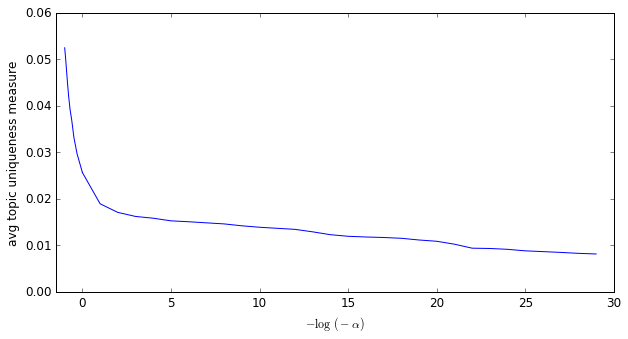

In [83]:
plt.figure(figsize=(10, 5))
plt.xlabel('$- \\log\\ (- \\alpha)$')
plt.ylabel('avg topic uniqueness measure')
plt.plot(minus_log_alphas, avg_uniqueness_measures)
plt.xlim(-1.5, 30)
plt.show()

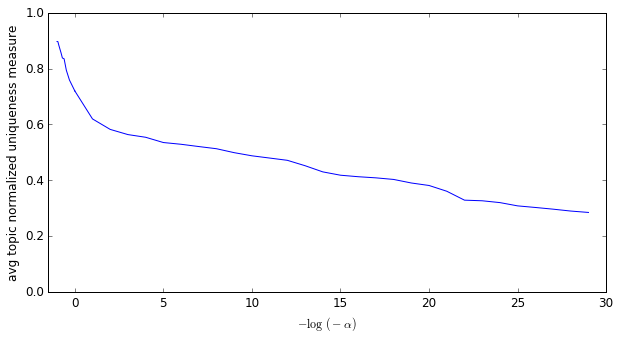

In [84]:
plt.figure(figsize=(10, 5))
plt.xlabel('$- \\log\\ (- \\alpha)$')
plt.ylabel('avg topic normalized uniqueness measure')
plt.plot(minus_log_alphas, avg_normalized_uniqueness_measures)
plt.ylim(0, 1)
plt.xlim(-1.5, 30)
plt.show()

#### Даже небольшого разреживания хватает, чтобы темы стали cущественно уникальными

In [85]:
minus_log_alphas = []
avg_uniqueness_measures2 = []
avg_normalized_uniqueness_measures2 = []
for alpha in alpha_values:
    print alpha
    minus_log_alphas.append(-np.log10(-alpha))
    phi, theta = perform_lda(5, alpha, -0.1)
    ums, nums = calc_phi_uniqueness_measures(phi)
    avg_uniqueness_measures2.append(np.mean(ums))
    avg_normalized_uniqueness_measures2.append(np.mean(nums))

-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
-1
-0.1
-0.01
-0.001
-0.0001
-1e-05
-1e-06
-1e-07
-1e-08
-1e-09
-1e-10
-1e-11
-1e-12
-1e-13
-1e-14
-1e-15
-1e-16
-1e-17
-1e-18
-1e-19
-1e-20
-1e-21
-1e-22
-1e-23
-1e-24
-1e-25
-1e-26
-1e-27
-1e-28
-1e-29


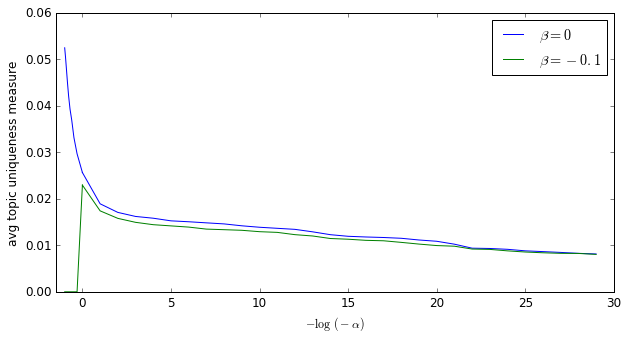

In [86]:
plt.figure(figsize=(10, 5))
plt.xlabel('$- \\log\\ (- \\alpha)$')
plt.ylabel('avg topic uniqueness measure')
plt.xlim(-1.5, 30)
plt.plot(minus_log_alphas, avg_uniqueness_measures)
plt.plot(minus_log_alphas, avg_uniqueness_measures2)
plt.legend(['$\\beta = 0$', '$\\beta = -0.1$', '$\\beta = 0.1$'])
plt.show()

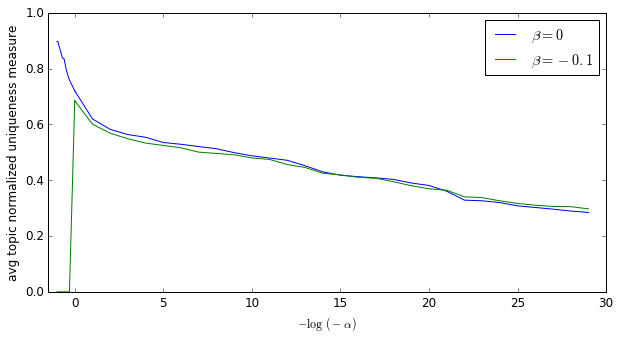

In [87]:
plt.figure(figsize=(10, 5))
plt.xlabel('$- \\log\\ (- \\alpha)$')
plt.ylabel('avg topic normalized uniqueness measure')
plt.ylim(0, 1)
plt.xlim(-1.5, 30)
plt.plot(minus_log_alphas, avg_normalized_uniqueness_measures)
plt.plot(minus_log_alphas, avg_normalized_uniqueness_measures2)
plt.legend(['$\\beta = 0$', '$\\beta = -0.1$', '$\\beta = 0.1$'])
plt.show()

#### Разреживание  $\Theta$ заставляет темы быть более сглаженными, что сказывается негативно на их единственности

In [88]:
minus_log_alphas = []
avg_uniqueness_measures3 = []
avg_normalized_uniqueness_measures3 = []
for alpha in alpha_values:
    print alpha
    minus_log_alphas.append(-np.log10(-alpha))
    phi, theta = perform_lda(5, alpha, 0.1)
    ums, nums = calc_phi_uniqueness_measures(phi)
    avg_uniqueness_measures3.append(np.mean(ums))
    avg_normalized_uniqueness_measures3.append(np.mean(nums))

-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
-1
-0.1
-0.01
-0.001
-0.0001
-1e-05
-1e-06
-1e-07
-1e-08
-1e-09
-1e-10
-1e-11
-1e-12
-1e-13
-1e-14
-1e-15
-1e-16
-1e-17
-1e-18
-1e-19
-1e-20
-1e-21
-1e-22
-1e-23
-1e-24
-1e-25
-1e-26
-1e-27
-1e-28
-1e-29


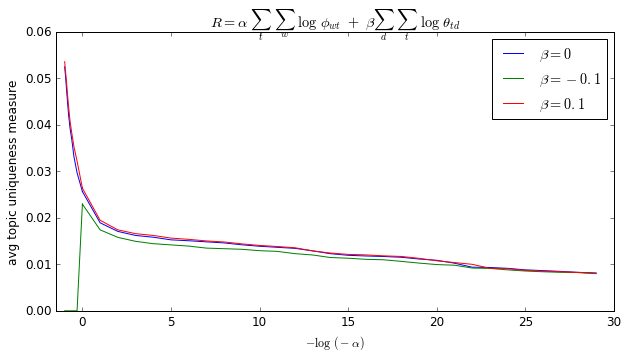

In [89]:
plt.figure(figsize=(10, 5))
plt.title('$R = \\alpha\\ \\sum_t\\ \\sum_w\\ \\log\\ \\phi_{wt}\\ +\\ \\beta \\sum_d\\ \\sum_t\\ \\log\\ \\theta_{td}$')
plt.xlabel('$- \\log\\ (- \\alpha)$')
plt.ylabel('avg topic uniqueness measure')
plt.xlim(-1.5, 30)
plt.plot(minus_log_alphas, avg_uniqueness_measures)
plt.plot(minus_log_alphas, avg_uniqueness_measures2)
plt.plot(minus_log_alphas, avg_uniqueness_measures3)
plt.legend(['$\\beta = 0$', '$\\beta = -0.1$', '$\\beta = 0.1$'])
plt.show()

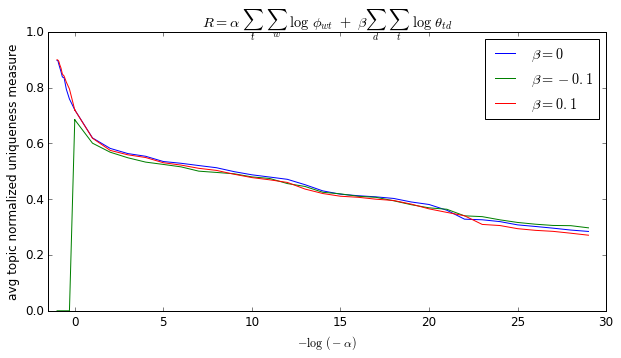

In [90]:
plt.figure(figsize=(10, 5))
plt.title('$R = \\alpha\\ \\sum_t\\ \\sum_w\\ \\log\\ \\phi_{wt}\\ +\\ \\beta \\sum_d\\ \\sum_t\\ \\log\\ \\theta_{td}$')
plt.xlabel('$- \\log\\ (- \\alpha)$')
plt.ylabel('avg topic normalized uniqueness measure')
plt.ylim(0, 1)
plt.xlim(-1.5, 30)
plt.plot(minus_log_alphas, avg_normalized_uniqueness_measures)
plt.plot(minus_log_alphas, avg_normalized_uniqueness_measures2)
plt.plot(minus_log_alphas, avg_normalized_uniqueness_measures3)
plt.legend(['$\\beta = 0$', '$\\beta = -0.1$', '$\\beta = 0.1$'])
plt.show()

#### Сглаживание  $\Theta$, наоборот, позволяет темам быть более разреженными, что сказывается нменого положительно на их единственности. Однако, так как есть ещё и условие на унитематические документы в теореме, то лучше не пользоваться сглаживанием документов.

In [258]:
topics_values = []
min_ums_values = []
min_nums_values = []
max_ums_values = []
max_nums_values = []
avg_ums_values = []
avg_nums_values = []
for T in xrange(2, 21):
    print T
    ums, nums = np.zeros(T), np.zeros(T)
    for seed in xrange(20):
        phi, theta = perform_lda(T, - 0.1, 0., seed=seed)
        dums, dnums = calc_phi_uniqueness_measures(phi)
        ums += dums
        nums += dnums
    ums /= 20
    nums /= 20
    
    topics_values.append(T)
    min_ums_values.append(np.min(ums))
    min_nums_values.append(np.min(nums))
    max_ums_values.append(np.max(ums))
    max_nums_values.append(np.max(nums))
    avg_ums_values.append(np.mean(ums))
    avg_nums_values.append(np.mean(nums))


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


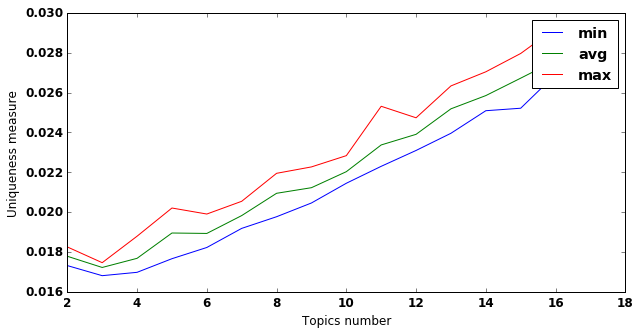

In [256]:
plt.figure(figsize=(10, 5))
plt.xlabel('Topics number')
plt.ylabel('Uniqueness measure')
plt.plot(topics_values, min_ums_values)
plt.plot(topics_values, avg_ums_values)
plt.plot(topics_values, max_ums_values)
plt.legend(['min', 'avg', 'max'])
plt.show()

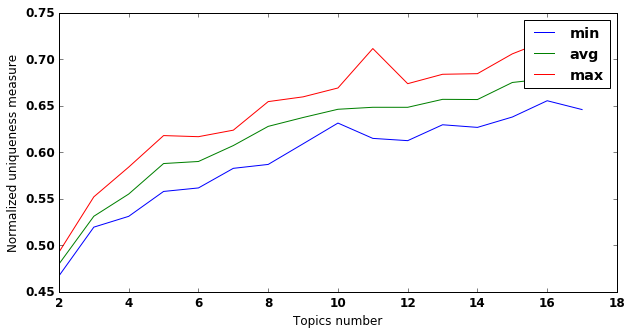

In [257]:
plt.figure(figsize=(10, 5))
plt.xlabel('Topics number')
plt.ylabel('Normalized uniqueness measure')
plt.plot(topics_values, min_nums_values)
plt.plot(topics_values, avg_nums_values)
plt.plot(topics_values, max_nums_values)
plt.legend(['min', 'avg', 'max'])
plt.show()

In [91]:
topics_values = []
min_ums_values = []
min_nums_values = []
max_ums_values = []
max_nums_values = []
avg_ums_values = []
avg_nums_values = []
for T in xrange(2, 41):
    print T
    ums, nums = np.zeros(T), np.zeros(T)
    for seed in xrange(20):
        phi, theta = perform_lda(T, - 0.1, 0., seed=seed)
        dums, dnums = calc_phi_uniqueness_measures(phi)
        ums += dums
        nums += dnums
    ums /= 20
    nums /= 20
    
    topics_values.append(T)
    min_ums_values.append(np.min(ums))
    min_nums_values.append(np.min(nums))
    max_ums_values.append(np.max(ums))
    max_nums_values.append(np.max(nums))
    avg_ums_values.append(np.mean(ums))
    avg_nums_values.append(np.mean(nums))


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


KeyboardInterrupt: 

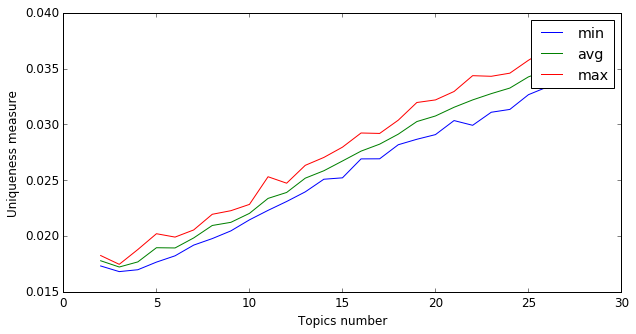

In [92]:
plt.figure(figsize=(10, 5))
plt.xlabel('Topics number')
plt.ylabel('Uniqueness measure')
plt.plot(topics_values, min_ums_values)
plt.plot(topics_values, avg_ums_values)
plt.plot(topics_values, max_ums_values)
plt.legend(['min', 'avg', 'max'])
plt.show()

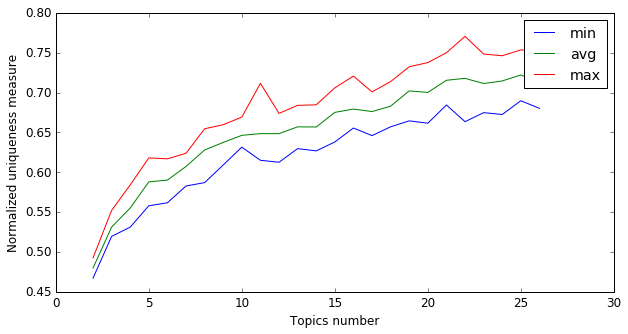

In [93]:
plt.figure(figsize=(10, 5))
plt.xlabel('Topics number')
plt.ylabel('Normalized uniqueness measure')
plt.plot(topics_values, min_nums_values)
plt.plot(topics_values, avg_nums_values)
plt.plot(topics_values, max_nums_values)
plt.legend(['min', 'avg', 'max'])
plt.show()

In [ ]:
topics_values = []
min_ums_values = []
min_nums_values = []
max_ums_values = []
max_nums_values = []
avg_ums_values = []
avg_nums_values = []
for T in xrange(2, 21):
    print T
    min_ums_value = 0 
    min_nums_value = 0 
    max_ums_value = 0 
    max_nums_value = 0 
    avg_ums_value = 0 
    avg_nums_value = 0 
    
    for seed in xrange(20):
        phi, theta = perform_lda(T, - 0.1, 0., seed=seed)
        dums, dnums = calc_phi_uniqueness_measures(phi)
        
        min_ums_value += np.min(dums) 
        min_nums_value += np.min(dnums) 
        max_ums_value += np.max(dums) 
        max_nums_value += np.max(dnums) 
        avg_ums_value += np.mean(dums) 
        avg_nums_value += np.mean(dnums) 
    
    min_ums_value /= 20 
    min_nums_value /= 20
    max_ums_value /= 20
    max_nums_value /= 20
    avg_ums_value /= 20
    avg_nums_value /= 20
    
    topics_values.append(T)
    min_ums_values.append(min_ums_value)
    min_nums_values.append(min_nums_value)
    max_ums_values.append(max_ums_value)
    max_nums_values.append(max_nums_value)
    avg_ums_values.append(avg_ums_value)
    avg_nums_values.append(avg_nums_value)


2
3
4
5
6
7
8
9
10
11
12

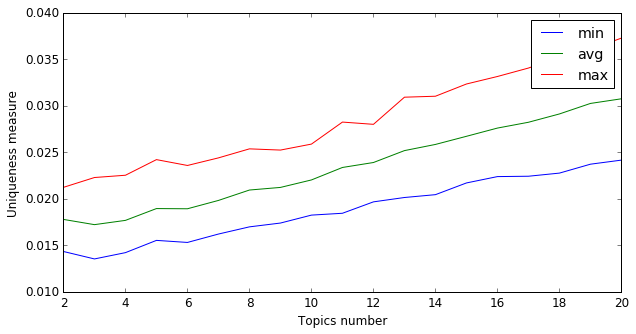

In [103]:
plt.figure(figsize=(10, 5))
plt.xlabel('Topics number')
plt.ylabel('Uniqueness measure')
plt.plot(topics_values, min_ums_values)
plt.plot(topics_values, avg_ums_values)
plt.plot(topics_values, max_ums_values)
plt.legend(['min', 'avg', 'max'])
plt.show()

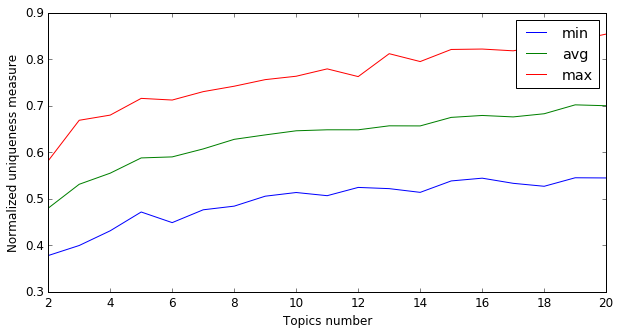

In [104]:
plt.figure(figsize=(10, 5))
plt.xlabel('Topics number')
plt.ylabel('Normalized uniqueness measure')
plt.plot(topics_values, min_nums_values)
plt.plot(topics_values, avg_nums_values)
plt.plot(topics_values, max_nums_values)
plt.legend(['min', 'avg', 'max'])
plt.show()

In [25]:
def perform_extended_lda(
    T, words_alpha, docs_alpha, seed=42, 
    freq_matrix=origin_freq_matrix, phi_zero_init=None, 
    theta_zero_init=None
):
    D, W = freq_matrix.shape

    np.random.seed(seed)

    phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
    if phi_zero_init is not None:
        phi_matrix[phi_zero_init < 1e-20] = 0.
    phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

    theta_matrix = np.random.uniform(size=(D, T)).astype(np.float64)
    if theta_zero_init is not None:
        theta_zero_init[theta_zero_init < 1e-20] = 0.
    theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

    no_selection_params = {
        'method': perform_e_step_update,
        'block_size': 50,
        'p_dwt_processor': trivial_p_dwt_processor
    }

    regularizations_list = np.zeros(50, dtype=object)
    params_list = np.zeros(50, dtype=object)

    regularizations_list[:10] = trivial_regularization
    regularizations_list[10:] = create_reg_lda(words_alpha, docs_alpha)
    params_list[:] = no_selection_params

    phi, theta = launch_em(
        freq_matrix=freq_matrix, 
        phi_matrix=phi_matrix,
        theta_matrix=theta_matrix,
        regularizations_list=regularizations_list,
        params_list=params_list,
        iters_count=50
    )
    
    return phi, theta

In [26]:
def plot_tsne(phis, colors, perplexity):
    model = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    X = model.fit_transform(phis) 
    plt.figure(figsize=(10, 8))
    plt.xlim(0.95 * min(X[:, 0]), 1.05 * max(X[:, 0]))
    plt.ylim(0.95 * min(X[:, 1]), 1.05 * max(X[:, 1]))
    sc = plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.colorbar(sc)
    plt.show()

In [27]:
def investigate_matrix_variance(matrices, title_prefix=''):
    smapes = []
    maes = []
    for i in xrange(len(matrices)):
        for j in xrange(len(matrices)):
            if i < j:
                indices = (matrices[i] > 1e-20) | (matrices[j] > 1e-20)
                fst = matrices[i][indices]
                snd = matrices[j][indices]
                smapes.append(np.mean(2. * np.abs(fst - snd) / (np.abs(fst) + np.abs(snd))))
                maes.append(np.mean(np.abs(fst - snd)))
                
    print 'Average pairwise MAE: {}'.format(np.mean(maes))
    print 'Pairwise MAE std: {}'.format(np.std(maes))
    plt.title(title_prefix + ' pairwise MAE distribution')
    plt.hist(maes, bins=50)
    plt.show()
    
    
    print 'Average pairwise sMAPE: {}'.format(np.mean(smapes))
    print 'Pairwise sMAPE std: {}'.format(np.std(smapes))
    plt.title(title_prefix + ' pairwise  sMAPE distribution')
    plt.hist(smapes, bins=50)
    plt.show()

In [28]:
def investigate_scalar_variance(values, title_prefix=''):
    plt.title(title_prefix + ' value distribution')
    plt.hist(values, bins=50)
    plt.show()
    
    smapes = []
    maes = []
    for i in xrange(len(values)):
        for j in xrange(len(values)):
            if i < j:
                fst = values[i]
                snd = values[j]
                smapes.append(np.mean(2. * np.abs(fst - snd) / (np.abs(fst) + np.abs(snd))))
                maes.append(np.mean(np.abs(fst - snd)))
                
    print 'Average pairwise MAE: {}'.format(np.mean(maes))
    print 'Pairwise MAE std: {}'.format(np.std(maes))
    plt.title(title_prefix + ' pairwise MAE distribution')
    plt.hist(maes, bins=50)
    plt.show()
    
    
    print 'Average pairwise sMAPE: {}'.format(np.mean(smapes))
    print 'Pairwise sMAPE std: {}'.format(np.std(smapes))
    plt.title(title_prefix + ' pairwise sMAPE distribution')
    plt.hist(smapes, bins=50)
    plt.show()

In [170]:
def smape_dist(a, b):
    indices = (a > 1e-20) | (b > 1e-20)
    fst = a[indices]
    snd = b[indices]
    return np.mean(2. * np.abs(fst - snd) / (np.abs(fst) + np.abs(snd)))

def mae_dist(a, b):
    indices = (a > 1e-20) | (b > 1e-20)
    fst = a[indices]
    snd = b[indices]
    return np.mean(np.abs(fst - snd))

def kl_dist(a, b):
    indices = (a > 1e-20)
    return np.sum(np.log(a[indices] / b[indices]) * a[indices])

def kl2_dist(a, b):
    c = (a + b) / 2.
    return kl_dist(a, c) + kl_dist(b, c)

def greed_match(fst, snd, dst_fun):
    T, W = fst.shape
    dists = []
    for t1 in xrange(T):
        dists.append(min(
            dst_fun(fst[t1, :], snd[t2, :])
            for t2 in xrange(T)
        ))
    return np.array(dists)

In [163]:
def check_phis(init_phi, phis, title_prefix=''):
    origin_phi = init_phi
    init_phi = init_phi.flatten()
    
    smapes = []
    maes = []
    greed_smapes = []
    greed_maes = []
    
    greed_kls = []
    greed_kl2s = []
    
    for phi in phis:
        indices = (phi > 1e-20) | (init_phi > 1e-20)
        fst = phi[indices]
        snd = init_phi[indices]
        smapes.append(np.mean(2. * np.abs(fst - snd) / (np.abs(fst) + np.abs(snd))))
        maes.append(np.mean(np.abs(fst - snd)))
        
        phi = phi.reshape(origin_phi.shape)
        greed_smapes.append(greed_match(origin_phi, phi, smape_dist))
        greed_maes.append(greed_match(origin_phi, phi, mae_dist))
        
        greed_kls.append(greed_match(origin_phi, phi, kl_dist))
        greed_kl2s.append(greed_match(origin_phi, phi, kl2_dist))
        
    print 'Average MAE: {}'.format(np.mean(maes))
    print 'MAE std: {}'.format(np.std(maes))
    print 'Min MAE: {}'.format(np.min(maes))
    print ''
    print 'Average sMAPE: {}'.format(np.mean(smapes))
    print 'sMAPE std: {}'.format(np.std(smapes))
    print 'Min sMAPE: {}'.format(np.min(smapes))
    print ''
    print 'Average greed MAE: {}'.format(np.mean(greed_maes))
    print 'greed MAE std: {}'.format(np.std(greed_maes))
    print ''
    print 'Average greed sMAPE: {}'.format(np.mean(greed_smapes))
    print 'greed sMAPE std: {}'.format(np.std(greed_smapes))
    print ''
    print 'Average greed KL: {}'.format(np.mean(greed_kls))
    print 'greed KL std: {}'.format(np.std(greed_kls))
    print ''
    print 'Average greed KL2: {}'.format(np.mean(greed_kl2s))
    print 'greed KL2 std: {}'.format(np.std(greed_kl2s))

# Просто обучаем sparse LDA

In [31]:
%%time
phis = []
perplexities = []
for seed in xrange(300):
    print seed
    phi, theta = perform_extended_lda(5, - 0.1, 0., seed=seed)
    phis.append(phi.flatten())
    perplexities.append(external_calculate_perplexity(origin_freq_matrix, phi, theta))
phis = np.array(phis)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## sparse LDA: phi points

/usr/share/python/yandex-ydf-toolbox/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


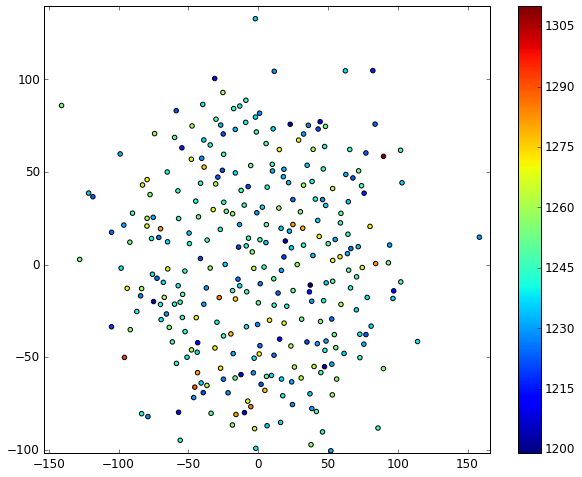

In [32]:
plot_tsne(phis, perplexities, 10)

## sparse LDA: phi variance

Average pairwise MAE: 0.000495226336785
Pairwise MAE std: 5.37063866381e-05


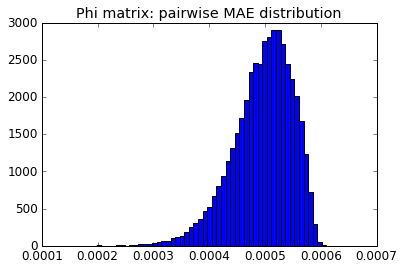

Average pairwise sMAPE: 1.48017124336
Pairwise sMAPE std: 0.0886980371546


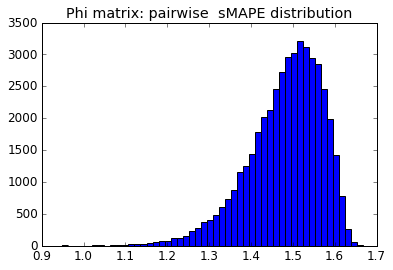

In [33]:
investigate_matrix_variance(phis, 'Phi matrix:')

## sparse LDA: perplexity variance

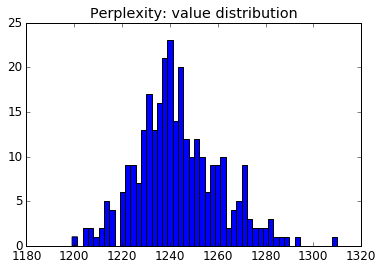

Average pairwise MAE: 19.2886747818
Pairwise MAE std: 15.1284134392


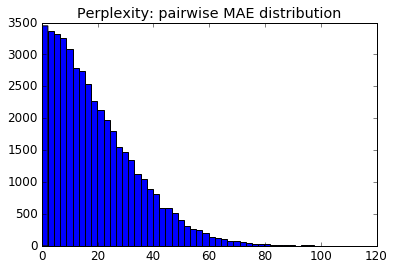

Average pairwise sMAPE: 0.0154891932318
Pairwise sMAPE std: 0.0121028550075


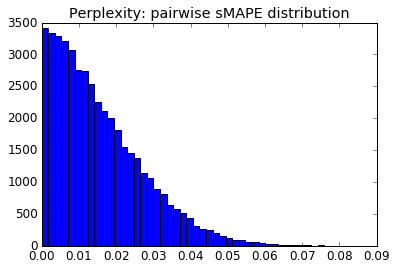

In [34]:
investigate_scalar_variance(perplexities, 'Perplexity:')

# Обучаем sparse LDA с начальными нулями

In [36]:
init_phi, init_theta = perform_extended_lda(5, - 0.1, 0., seed=42)

In [37]:
phis = []
perplexities = []
for seed in xrange(300):
    print seed
    phi, theta = perform_extended_lda(5, - 0.1, 0., seed=seed, phi_zero_init=init_phi, theta_zero_init=init_theta)
    phis.append(phi.flatten())
    perplexities.append(external_calculate_perplexity(origin_freq_matrix, phi, theta))
phis = np.array(phis)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## full initialized sparse LDA: phi points

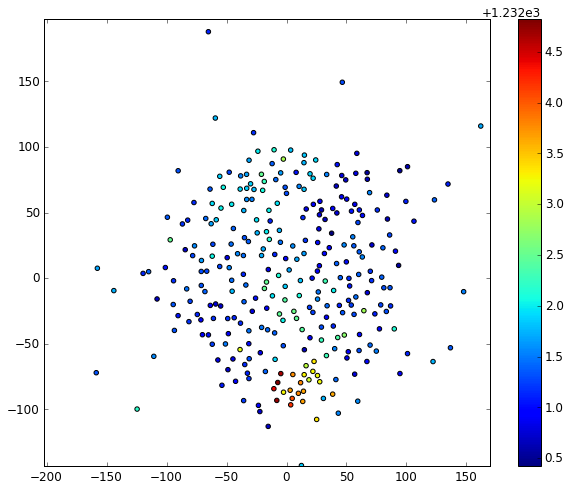

In [38]:
plot_tsne(phis, perplexities, 10)

## full initialized sparse LDA: phi variance

Average pairwise MAE: 3.70359307739e-05
Pairwise MAE std: 1.80608971912e-05


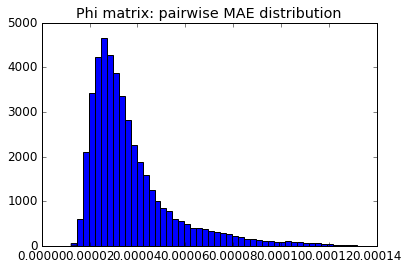

Average pairwise sMAPE: 0.149404013418
Pairwise sMAPE std: 0.0448361550026


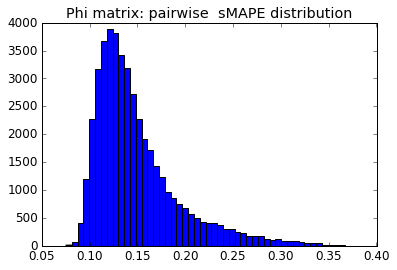

In [39]:
investigate_matrix_variance(phis, 'Phi matrix:')

## full initialized sparse LDA: perplexity variance

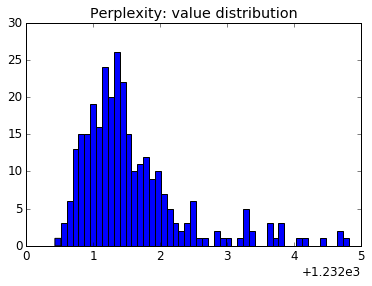

Average pairwise MAE: 0.78398169743
Pairwise MAE std: 0.778277734068


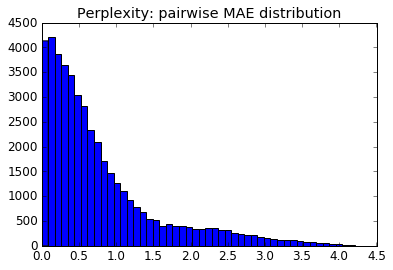

Average pairwise sMAPE: 0.000635351959063
Pairwise sMAPE std: 0.00063039785835


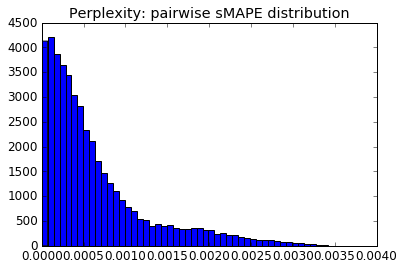

In [40]:
investigate_scalar_variance(perplexities, 'Perplexity:')

# phi initialized sparse LDA

In [41]:
phis = []
perplexities = []
for seed in xrange(300):
    print seed
    phi, theta = perform_extended_lda(5, - 0.1, 0., seed=seed, phi_zero_init=init_phi)
    phis.append(phi.flatten())
    perplexities.append(external_calculate_perplexity(origin_freq_matrix, phi, theta))
phis = np.array(phis)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## phi initialized sparse LDA: phi points

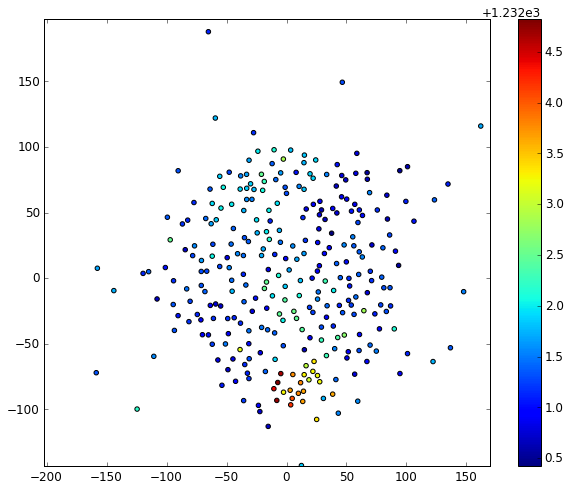

In [42]:
plot_tsne(phis, perplexities, 10)

## phi initialized sparse LDA: phi variance

Average pairwise MAE: 3.70359307739e-05
Pairwise MAE std: 1.80608971912e-05


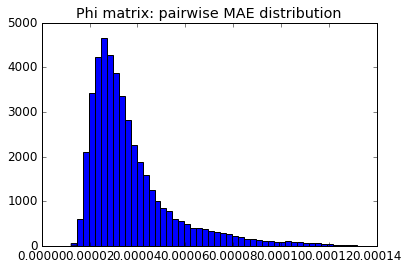

Average pairwise sMAPE: 0.149404013418
Pairwise sMAPE std: 0.0448361550026


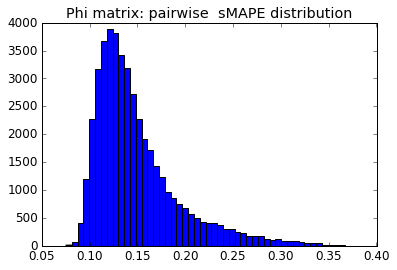

In [43]:
investigate_matrix_variance(phis, 'Phi matrix:')

## phi initialized sparse LDA: perplexity variance

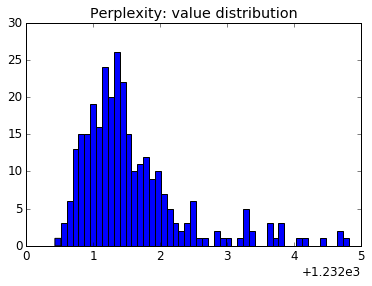

Average pairwise MAE: 0.78398169743
Pairwise MAE std: 0.778277734068


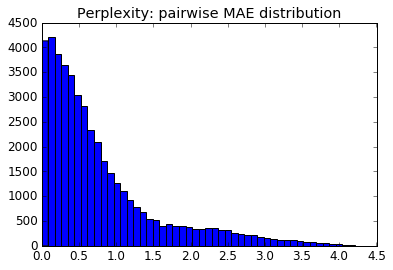

Average pairwise sMAPE: 0.000635351959063
Pairwise sMAPE std: 0.00063039785835


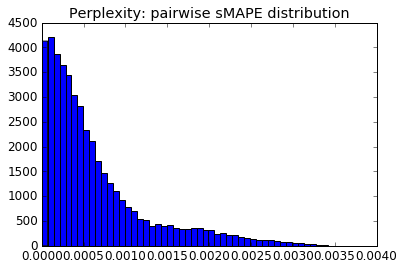

In [44]:
investigate_scalar_variance(perplexities, 'Perplexity:')

# Syntetic sparse LDA

In [45]:
m = np.dot(init_theta, init_phi)
print np.sum(np.isnan(m))
m[np.isnan(m)] = 0.
new_freq_matrix = scipy.sparse.csr_matrix(m)

325611


In [46]:
phis = []
perplexities = []
for seed in xrange(30):
    print seed
    phi, theta = perform_extended_lda(5, - 0.1, 0., seed=seed, freq_matrix=new_freq_matrix)
    phis.append(phi.flatten())
    perplexities.append(external_calculate_perplexity(new_freq_matrix, phi, theta))
phis = np.array(phis)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


## Syntetic sparse LDA: phi points

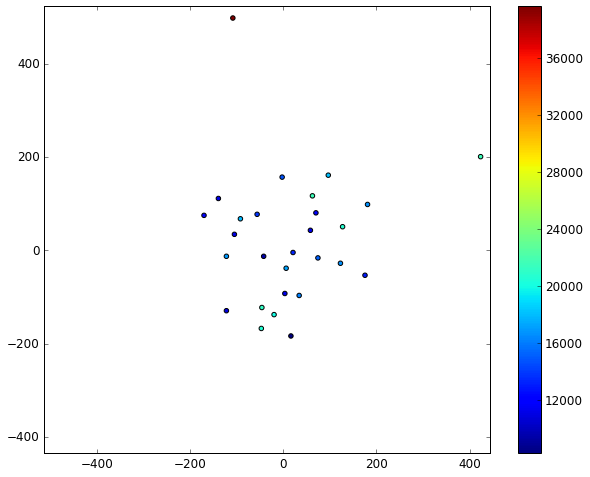

In [47]:
plot_tsne(phis, perplexities, 5)

## Syntetic sparse LDA: phi variance

Average pairwise MAE: 0.00167224756138
Pairwise MAE std: 0.000141261512943


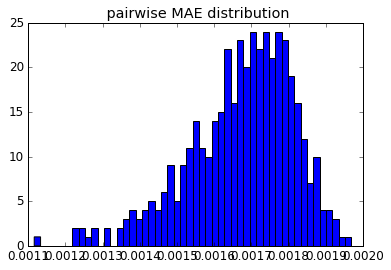

Average pairwise sMAPE: 1.79082757009
Pairwise sMAPE std: 0.128419580664


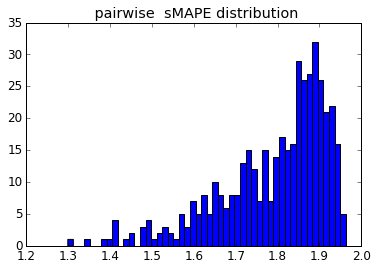

In [48]:
investigate_matrix_variance(phis)

## Syntetic sparse LDA: perplexity variance

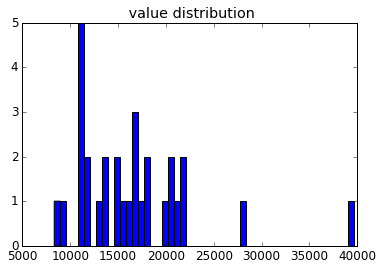

Average pairwise MAE: 6418.11011885
Pairwise MAE std: 6071.99651003


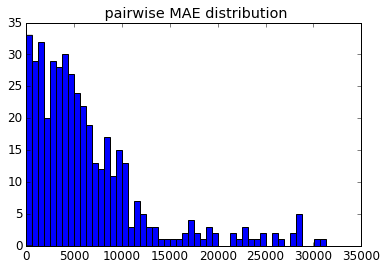

Average pairwise sMAPE: 0.362149800966
Pairwise sMAPE std: 0.26293599764


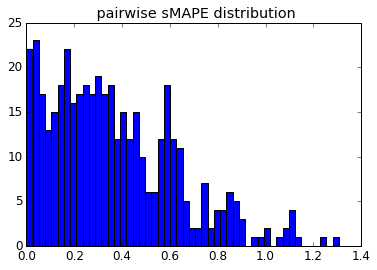

In [49]:
investigate_scalar_variance(perplexities)

# full initialized Syntetic sparse LDA

In [50]:
phis = []
perplexities = []
for seed in xrange(30):
    print seed
    phi, _ = perform_extended_lda(5, - 0.1, 0., seed=seed, phi_zero_init=init_phi, theta_zero_init=init_theta, freq_matrix=new_freq_matrix)
    phis.append(phi.flatten())
    perplexities.append(external_calculate_perplexity(new_freq_matrix, phi, theta))
phis = np.array(phis)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


## full initialized Syntetic sparse LDA: phi points

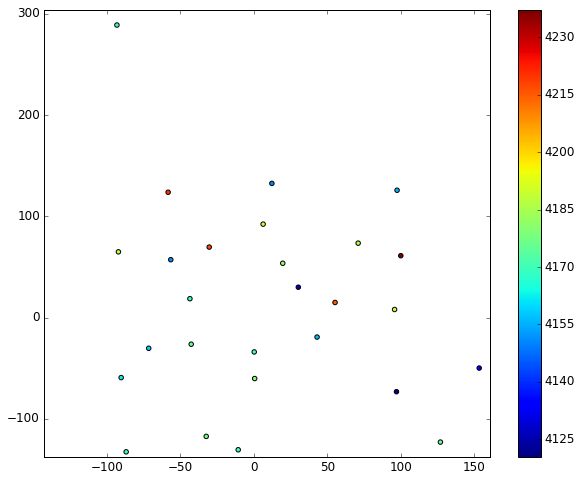

In [51]:
plot_tsne(phis, perplexities, 5)

## full initialized Syntetic sparse LDA: phi variance

Average pairwise MAE: 2.05312122596e-05
Pairwise MAE std: 6.47460221598e-06


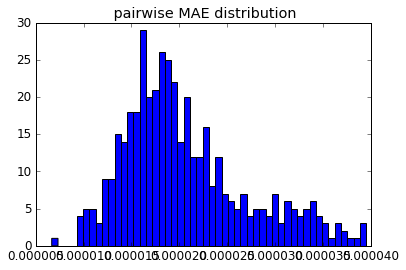

Average pairwise sMAPE: 0.0373818163926
Pairwise sMAPE std: 0.00860055628449


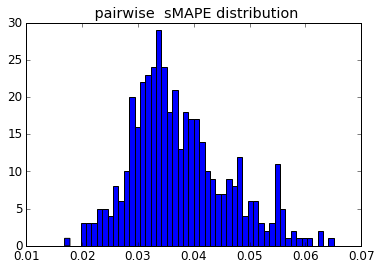

In [52]:
investigate_matrix_variance(phis)

## full initialized Syntetic sparse LDA: perplexity variance

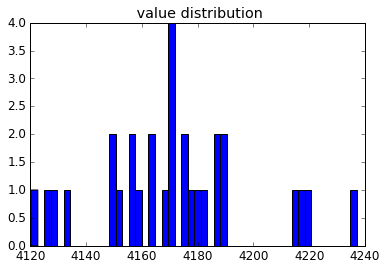

Average pairwise MAE: 30.9663737511
Pairwise MAE std: 23.7493679953


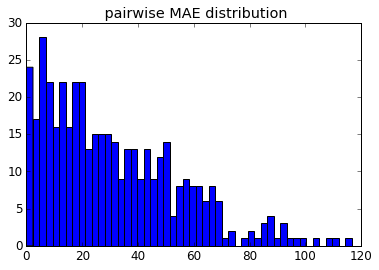

Average pairwise sMAPE: 0.00741931032787
Pairwise sMAPE std: 0.00568200707055


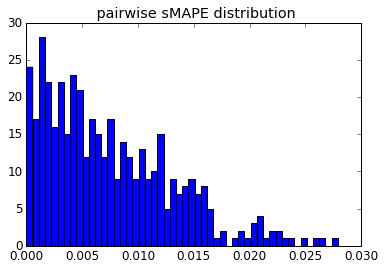

In [53]:
investigate_scalar_variance(perplexities)

## Оценка приближения ответа

In [54]:
check_phis(init_phi, phis)

Average pairwise MAE: 0.000343596475507
Pairwise MAE std: 4.98462275993e-07
Min pairwise MAE: 0.000342225043424

Average pairwise sMAPE: 1.32928564772
Pairwise sMAPE std: 0.000572403193326
Min pairwise sMAPE: 1.32807434419


# Full initialized PLSA

In [55]:
new_init_phi, new_init_theta = perform_extended_lda(5, 0., 0., seed=seed, phi_zero_init=init_phi, theta_zero_init=init_theta)

In [165]:
phis = []
perplexities = []
for seed in xrange(300):
    print seed
    phi, theta = perform_extended_lda(5, 0., 0., seed=seed, phi_zero_init=new_init_phi, theta_zero_init=new_init_theta)
    phis.append(phi.flatten())
    perplexities.append(external_calculate_perplexity(origin_freq_matrix, phi, theta))
phis = np.array(phis)

0
1
2
3
4
5
6
7
8
9


## Full initialized PLSA: phi points

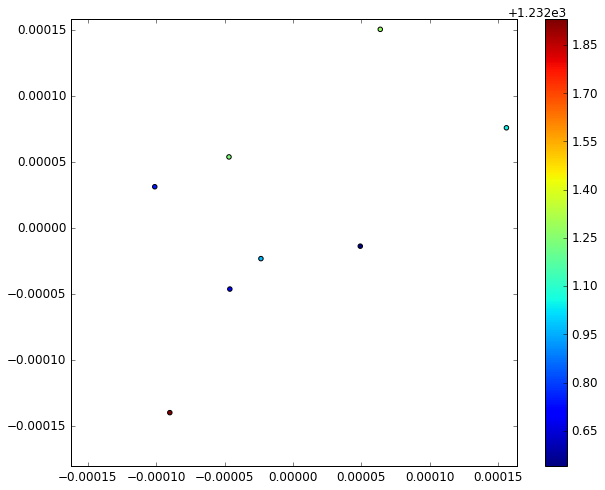

In [166]:
plot_tsne(phis, perplexities, 10)

## Full initialized PLSA: phi variance

Average pairwise MAE: 2.68117846216e-05
Pairwise MAE std: 8.27046142733e-06


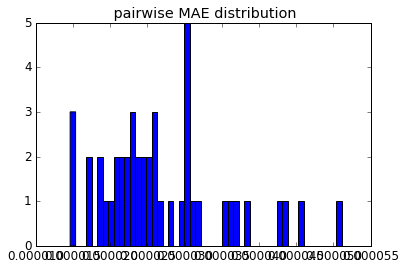

Average pairwise sMAPE: 0.110856178545
Pairwise sMAPE std: 0.0213334998765


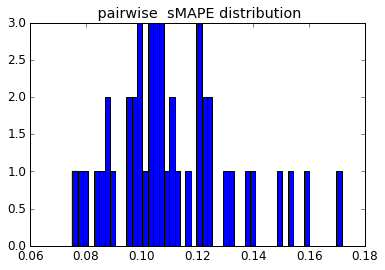

In [167]:
investigate_matrix_variance(phis)

## Full initialized PLSA: perplexity variance

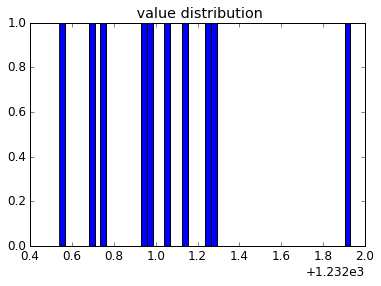

Average pairwise MAE: 0.439808458933
Pairwise MAE std: 0.334254870331


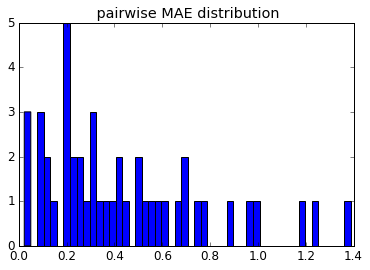

Average pairwise sMAPE: 0.00035665578088
Pairwise sMAPE std: 0.000271009230588


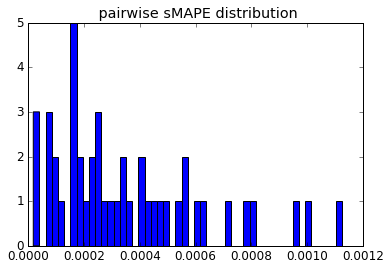

In [168]:
investigate_scalar_variance(perplexities)

## Оценим качество приближения

In [169]:
check_phis(new_init_phi, phis)

[0.10124774802687173, 0.056174294047717684, 0.082605464086597635, 0.074983625927620215, 0.11394829339357963]
[2.4403266530265103e-05, 8.7252863735336381e-06, 1.8173974449090612e-05, 1.0031718096727119e-05, 2.6391418741879243e-05]
[0.0064157602769983214, 0.0027166542418628277, 0.010732918484454712, 0.00336997390097293, 0.0098303379000195465]
[0.0035875534765067206, 0.00077722703684899729, 0.0014805713730395001, 0.0014139774022051497, 0.0032417771366905906]
[0.15782806095416277, 0.083875391119796708, 0.081530427507370218, 0.083766896524588436, 0.19247072849800029]
[4.5509080109311709e-05, 2.0636017741693419e-05, 1.6014101061395312e-05, 1.3503740476481717e-05, 5.2704490204326047e-05]
[0.016229416597169088, 0.0065086912189681722, 0.01987822944008201, 0.0074766756042631468, 0.023097437516529984]
[0.0059917297868911906, 0.0031382345693869431, 0.0020932501277038554, 0.0014778755498641486, 0.010084115333773975]
[0.12789861287225537, 0.064422582955132576, 0.078413569179189985, 0.105056638480458

# Syntetic PLSA

In [61]:
m = np.dot(new_init_theta, new_init_phi)
print np.sum(np.isnan(m))
m[np.isnan(m)] = 0.
new_freq_matrix = scipy.sparse.csr_matrix(m)

325611


In [67]:
phis = []
perplexities = []
for seed in xrange(30):
    print seed
    phi, theta = perform_extended_lda(5, 0., 0., seed=seed, freq_matrix=new_freq_matrix)
    phis.append(phi.flatten())
    perplexities.append(external_calculate_perplexity(new_freq_matrix, phi, theta))
phis = np.array(phis)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


## Full initialized syntetic PLSA: phi points

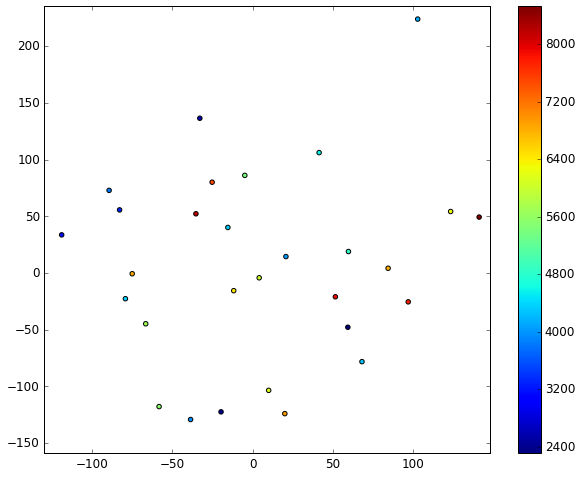

In [68]:
plot_tsne(phis, perplexities, 5)

## Full initialized syntetic PLSA: phi variance

Average pairwise MAE: 0.000331873125716
Pairwise MAE std: 7.50784993851e-05


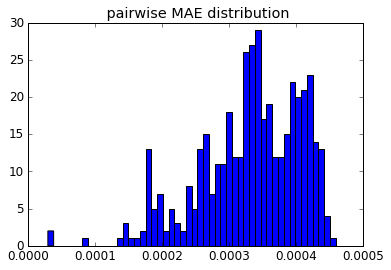

Average pairwise sMAPE: 1.43275718352
Pairwise sMAPE std: 0.148544240696


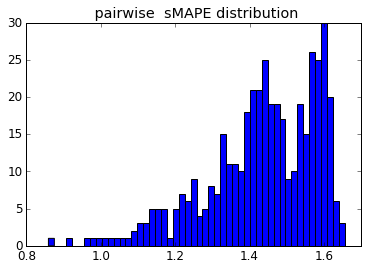

In [69]:
investigate_matrix_variance(phis)

## Full initialized syntetic PLSA: perplexity variance

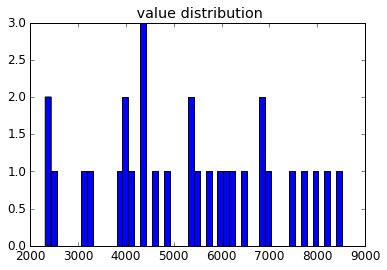

Average pairwise MAE: 2065.44759914
Pairwise MAE std: 1413.98308227


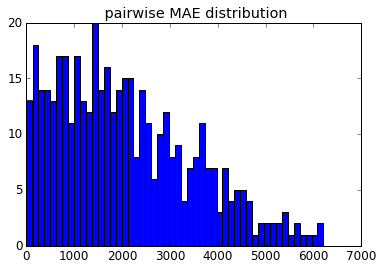

Average pairwise sMAPE: 0.40166472302
Pairwise sMAPE std: 0.276438761436


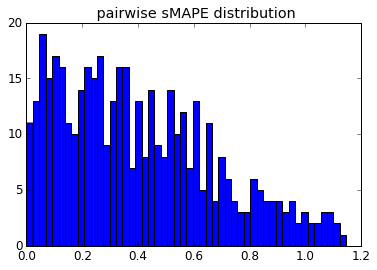

In [70]:
investigate_scalar_variance(perplexities)

## Оценим качество приближения

In [71]:
check_phis(new_init_phi, phis)

Average pairwise MAE: 0.000347162547366
Pairwise MAE std: 7.01808054377e-05
Min pairwise MAE: 0.000182843953258

Average pairwise sMAPE: 1.54101187177
Pairwise sMAPE std: 0.112724596664
Min pairwise sMAPE: 1.24193597139


# Full initialized syntetic PLSA

In [172]:
phis = []
perplexities = []
for seed in xrange(30):
    print seed
    phi, theta = perform_extended_lda(5, 0., 0., seed=seed, phi_zero_init=new_init_phi, theta_zero_init=new_init_theta, freq_matrix=new_freq_matrix)
    phis.append(phi.flatten())
    perplexities.append(external_calculate_perplexity(new_freq_matrix, phi, theta))
phis = np.array(phis)

0
1


## Full initialized syntetic PLSA: phi points

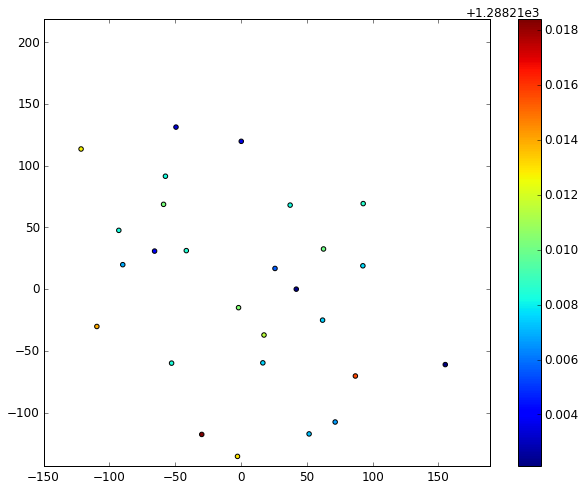

In [63]:
plot_tsne(phis, perplexities, 5)

## Full initialized syntetic PLSA: phi variance

Average pairwise MAE: 4.08405721392e-08
Pairwise MAE std: 1.78578857899e-08


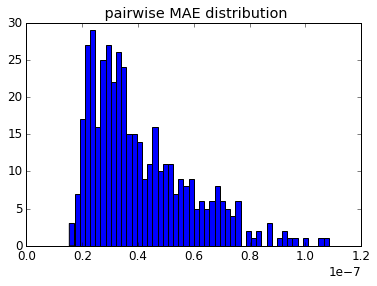

Average pairwise sMAPE: 0.00282284077676
Pairwise sMAPE std: 0.000388703331192


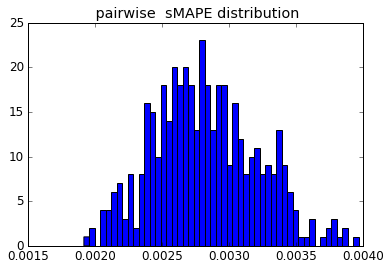

In [64]:
investigate_matrix_variance(phis)

## Full initialized syntetic PLSA: perplexity variance

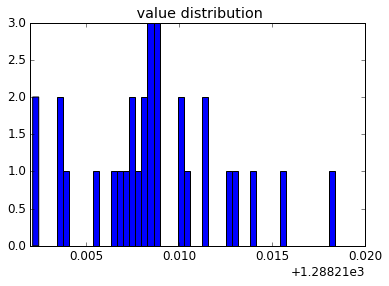

Average pairwise MAE: 0.00421551404716
Pairwise MAE std: 0.00326526987056


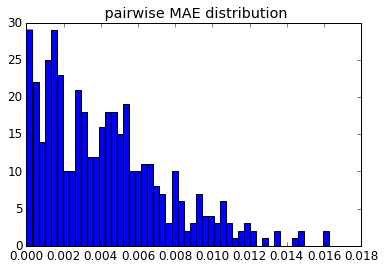

Average pairwise sMAPE: 3.27235804405e-06
Pairwise sMAPE std: 2.53471431445e-06


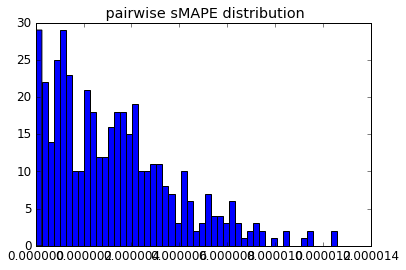

In [65]:
investigate_scalar_variance(perplexities)

## Оценим качество приближения

In [173]:
check_phis(new_init_phi, phis)

Average MAE: 4.5216437819e-07
MAE std: 1.04365682504e-08
Min MAE: 4.41727809939e-07

Average sMAPE: 0.0117222622148
sMAPE std: 5.63205808088e-05
Min sMAPE: 0.011665941634

Average greed MAE: 4.75108995545e-07
greed MAE std: 6.47842733535e-07

Average greed sMAPE: 0.0119314022078
greed sMAPE std: 0.00577773646143

Average greed KL: 7.07669533871e-05
greed KL std: 0.000136165342031

Average greed KL2: 4.42009853923e-05
greed KL2 std: 8.55497773661e-05


In [106]:
new_init_phi_, new_init_theta_ = perform_extended_lda(5, 0., 0., seed=seed, phi_zero_init=init_phi, theta_zero_init=init_theta)

In [107]:
new_init_phi, new_init_theta = perform_extended_lda(5, 0., 0., seed=seed, phi_zero_init=new_init_phi_, theta_zero_init=new_init_theta_)

In [110]:
m = np.dot(new_init_theta, new_init_phi)
print np.sum(np.isnan(m))
m[np.isnan(m)] = 0.
new_freq_matrix = scipy.sparse.csr_matrix(m)

325611


In [159]:
phis = []
perplexities = []
for seed in xrange(30):
    print seed
    phi, theta = perform_extended_lda(5, 0., 0., seed=seed, freq_matrix=new_freq_matrix)
    phis.append(phi.flatten())
    perplexities.append(external_calculate_perplexity(new_freq_matrix, phi, theta))
phis = np.array(phis)

0
1


Average pairwise MAE: 0.000262052465006
Pairwise MAE std: 0.0


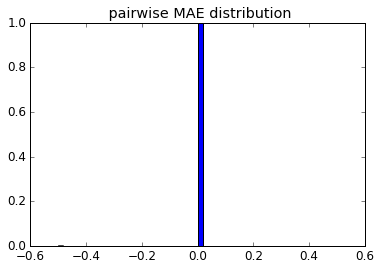

Average pairwise sMAPE: 1.32653544809
Pairwise sMAPE std: 0.0


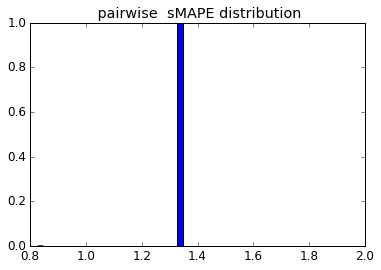

In [160]:
investigate_matrix_variance(phis)

In [171]:
check_phis(new_init_phi, phis)

Average MAE: 2.46547224268e-05
MAE std: 9.31660277924e-06
Min MAE: 1.37114848242e-05

Average sMAPE: 0.104380484074
sMAPE std: 0.0240306951638
Min sMAPE: 0.0739545458033

Average greed MAE: 2.46585110068e-05
greed MAE std: 1.62787200287e-05

Average greed sMAPE: 0.104328177804
greed sMAPE std: 0.0439150402309

Average greed KL: 0.011749650965
greed KL std: 0.0107251023316

Average greed KL2: 0.00333467644438
greed KL2 std: 0.0035249071482
